# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [3]:
# filter warning message
import warnings
warnings.filterwarnings('ignore')

In [4]:
# import libraries
import time
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

In [5]:
# load data from database
engine = create_engine('sqlite:///data/data.sqlite')
df = pd.read_sql("SELECT * FROM message_response", con=engine)
df.isnull().any().sum()

0

In [6]:
# convert category column data type from int64 to int8
for column in df.columns[2:]:
    df[column] = df[column].astype('int8')

In [7]:
# and message from object to string
df['message'] = df['message'].astype(str)

In [8]:
# split features and labels
X = df['message'].values
Y = df.drop(['message', 'genre'], axis=1).copy().values

In [9]:
X.shape

(26207,)

In [11]:
# with 36 categories
Y.shape

(26207, 36)

### 2. Write a tokenization function to process your text data

In [12]:
# import libraries for NLTK
import re
import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
# stopwords.words('english')

[nltk_data] Downloading package punkt to /home/uno/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/uno/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/uno/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/uno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
# libraries for sklearn
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [14]:
def tokenize(text):
    '''Process text to lower case, remove stopwords, and lemmatize.

    Input: A line of text
    Return: a list of words (tokens)
    '''
        
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    tokens = word_tokenize(text)
    
    tokens = [w for w in tokens if w not in stopwords.words('english')]
    
    lemmatizer = WordNetLemmatizer()
    
    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)
    return clean_tokens

### 5. Train and test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [16]:
# print out scores with `classification_report`
# three types of scores: 
# 1. precision -- portion of the corectly classified to the total classified
# 2. recall -- portion of the corectly classified to the total items should be corectly classified
# 3. f1-score -- weighted balance of recall and precision
# more on these: https://en.wikipedia.org/wiki/F-score

labels = df.columns[2:]
def test_report(Y_predict, Y_test, verbose=False):
    '''return a dictionary of scores from classification report'''
    
    scores = dict()
    for i in range(len(labels)):
        report = classification_report(Y_predict[:, i], Y_test[:, i], 
                                           output_dict=True)
        if verbose:
            scores.update({labels[i]: report})
        else:
            scores.update({labels[i]: report['weighted avg']})
    return scores

In [17]:
def quick_eval(model):
    Y_predict = model.predict(X_test)
    scores = test_report(Y_predict, Y_test)
    df_scores = pd.DataFrame.from_dict(data=scores, orient='index')
    print(df_scores.mean(axis=0))
    return df_scores

In [18]:
# with Pipeline only, not GridSearch
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.7, random_state=1)
pipeline_knn = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(KNeighborsClassifier()))
])
pipeline_knn.fit(X_train, Y_train)
quick_eval(pipeline_knn)

precision        0.951263
recall           0.911741
f1-score         0.929251
support      18345.000000
dtype: float64


,precision,recall,f1-score,support
related,0.940639,0.748487,0.829029,18345
request,0.795049,0.775198,0.784481,18345
offer,1.000000,0.995312,0.997651,18345
aid_related,0.547857,0.530717,0.537521,18345
medical_help,0.998868,0.918942,0.957182,18345
medical_products,0.999329,0.949741,0.973904,18345
search_and_rescue,0.999889,0.971872,0.985682,18345
security,0.999890,0.982720,0.991231,18345
military,0.999778,0.968166,0.983718,18345
child_alone,1.000000,1.000000,1.000000,18345


In [27]:
# experiment with GridSearchCV and parameters

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.7, random_state=1)
pipeline_knn = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(KNeighborsClassifier()))
])
parameters = {
#         'vect__stop_words': (None, 'english'),
        'vect__ngram_range': ((1, 1), (1, 2)),
        'vect__max_df': (0.5, 0.75, 1.0),
        'vect__max_features': (None, 100, 1000, 10000),
        'tfidf__use_idf': (True, False),
#         'tfidf__smooth_idf': (True, False),
#         'tfidf__sublinear_tf': (True, False),
        'clf__estimator__n_neighbors': [3, 5, 10],
#         'clf__estimator__weights': ['uniform', 'distance'],
#         'clf__estimator__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
#         'clf__estimator__leaf_size': [1,10,30,50],
#         'clf__estimator__p': [1,2,3]
    }
cv = GridSearchCV(pipeline_knn, param_grid=parameters, cv=3, verbose=True, n_jobs=-1)

start = time.time()
cv.fit(X_train, Y_train)
last_for = time.time() - start
print(f'Total training time: {last_for:.1f} seconds')

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed: 27.8min finished


Total training time: 1685.9 seconds


In [28]:
# see what the best parameters for fitting so far
cv.best_estimator_

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.5,
                                 max_features=1000, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at 0x7fde48d91b70>,
                                 vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultiOutputClassifier(estimator=KNeighborsClassifier(algorithm='auto',

In [29]:
quick_eval(cv)

precision        0.978857
recall           0.922109
f1-score         0.947645
support      18345.000000
dtype: float64


,precision,recall,f1-score,support
related,0.636927,0.637176,0.637009,18345
request,0.966008,0.823930,0.886471,18345
offer,1.000000,0.995312,0.997651,18345
aid_related,0.733332,0.559062,0.617857,18345
medical_help,1.000000,0.919324,0.957966,18345
medical_products,1.000000,0.950068,0.974395,18345
search_and_rescue,1.000000,0.971927,0.985764,18345
security,1.000000,0.982775,0.991312,18345
military,1.000000,0.968275,0.983882,18345
child_alone,1.000000,1.000000,1.000000,18345


In [30]:
# we can fix some features and fine tune by another run
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.7, random_state=1)
pipeline_knn = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize, ngram_range=(1,1))),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(KNeighborsClassifier()))
])
parameters = {
#         'vect__stop_words': (None, 'english'),
#         'vect__ngram_range': ((1, 1)),
        'vect__max_df': (0.25, 0.5, 0.75),
        'vect__max_features': (500, 1000, 2000),
        'tfidf__use_idf': (True, False),
#         'tfidf__smooth_idf': (True, False),
#         'tfidf__sublinear_tf': (True, False),
        'clf__estimator__n_neighbors': [5, 10, 20],
#         'clf__estimator__weights': ['uniform', 'distance'],
#         'clf__estimator__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
#         'clf__estimator__leaf_size': [1,10,30,50],
#         'clf__estimator__p': [1,2,3]
    }
cv = GridSearchCV(pipeline_knn, param_grid=parameters, cv=5, verbose=True, n_jobs=12)

start = time.time()
cv.fit(X_train, Y_train)
last_for = time.time() - start
print(f'Total training time: {last_for:.1f} seconds')

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  2.3min
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed: 11.0min
[Parallel(n_jobs=12)]: Done 270 out of 270 | elapsed: 16.3min finished


Total training time: 995.3 seconds


In [31]:
# check again
cv.best_estimator_

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.25,
                                 max_features=2000, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at 0x7fde48d91b70>,
                                 vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultiOutputClassifier(estimator=KNeighborsClassifier(algorithm='auto'

In [32]:
quick_eval(cv)

precision        0.981909
recall           0.919825
f1-score         0.946952
support      18345.000000
dtype: float64


,precision,recall,f1-score,support
related,0.516249,0.538021,0.506490,18345
request,0.974985,0.826765,0.892123,18345
offer,1.000000,0.995312,0.997651,18345
aid_related,0.900751,0.574053,0.689944,18345
medical_help,1.000000,0.919324,0.957966,18345
medical_products,1.000000,0.950068,0.974395,18345
search_and_rescue,1.000000,0.971927,0.985764,18345
security,1.000000,0.982775,0.991312,18345
military,1.000000,0.968275,0.983882,18345
child_alone,1.000000,1.000000,1.000000,18345


In [33]:
# using trained model to predict on test data 
Y_predict = cv.predict(X_test)

In [34]:
Y_predict.shape

(18345, 36)

In [35]:
from sklearn.metrics import accuracy_score

In [36]:
accuracy_score(Y_predict[:, 0], Y_test[:, 0])

0.5380212591986917

In [38]:
scores = test_report(Y_predict, Y_test)

In [62]:
scores

{'related': {'precision': 0.5162494890475287,
  'recall': 0.5380212591986917,
  'f1-score': 0.5064899453819527,
  'support': 18345},
 'request': {'precision': 0.9749852714174783,
  'recall': 0.826764786045244,
  'f1-score': 0.8921232516751485,
  'support': 18345},
 'offer': {'precision': 1.0,
  'recall': 0.9953120741346416,
  'f1-score': 0.9976505299967217,
  'support': 18345},
 'aid_related': {'precision': 0.9007508580118859,
  'recall': 0.5740528754429,
  'f1-score': 0.6899442788241301,
  'support': 18345},
 'medical_help': {'precision': 1.0,
  'recall': 0.9193240665031344,
  'f1-score': 0.9579664867935246,
  'support': 18345},
 'medical_products': {'precision': 1.0,
  'recall': 0.9500681384573453,
  'f1-score': 0.9743948118745456,
  'support': 18345},
 'search_and_rescue': {'precision': 1.0,
  'recall': 0.9719269555737258,
  'f1-score': 0.9857636489288182,
  'support': 18345},
 'security': {'precision': 1.0,
  'recall': 0.9827745979831016,
  'f1-score': 0.9913124759443558,
  'suppor

In [61]:
with open('models/evaluate_score.txt', 'w+') as f:
    f.write(json.dumps(scores))

In [164]:
def visualize_report(score_report, title='Scores on test data'):
    '''visualize score report by matplotlib'''
    
    df_scores = pd.DataFrame.from_dict(data=scores, orient='index')
    fig, ax = plt.subplots(figsize=(10,6), facecolor='white')
    width = 0.2
    score_types = ['precision', 'recall', 'f1-score']
    x = np.arange(0, len(df_scores))
    for i, label in enumerate(score_types):
        ax.bar(x+i*width, df_scores[label], width=width, label=label)
    ax.set_xlim(0, len(df_scores))
    ax.xaxis.set_major_locator(MultipleLocator(1))
    cat_labels = list(df_scores.index)
    cat_labels.insert(0,'')
    ax.set_title(title)
    ax.set_xticklabels(cat_labels, rotation=90)
    fig.legend(ncol=3, loc='lower center')
    fig.tight_layout()
    fig.savefig('models/evaluate_score.png');
    return None

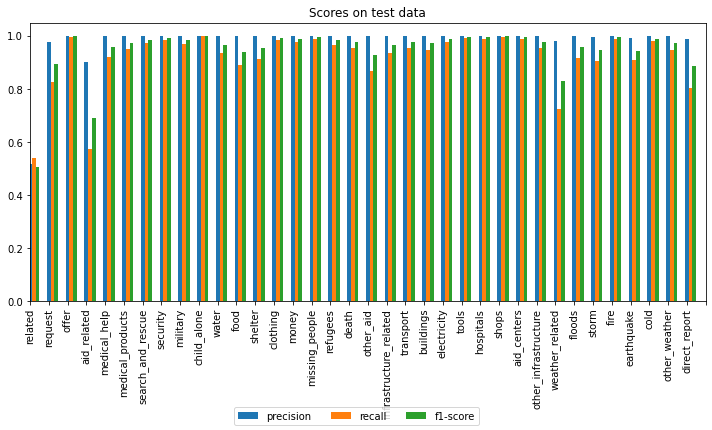

In [165]:
visualize_report(scores)

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [ ]:
# we can try another classifer
from sklearn.ensemble import RandomForestClassifier

In [ ]:
pipeline_rf = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier()))
])

In [ ]:
pipeline_rf.fit(X_train, Y_train)

In [ ]:
quick_eval(pipeline_rf)

In [ ]:
# experiment with GridSearchCV and parameters
# aborted after running too long

# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.7, random_state=1)
# pipeline_rf = Pipeline([
#     ('vect', CountVectorizer(tokenizer=tokenize)),
#     ('tfidf', TfidfTransformer()),
#     ('clf', MultiOutputClassifier(RandomForestClassifier()))
# ])
# parameters = {
#         'vect__ngram_range': ((1, 1), (1, 2)),
#         'vect__max_df': (0.5, 0.75, 1.0),
#         'vect__max_features': (None, 100, 1000, 10000),
#         'tfidf__use_idf': (True, False),
#         'clf__estimator__n_estimators': [10, 50, 200],
#     }
# cv = GridSearchCV(pipeline_rf, param_grid=parameters, cv=3, verbose=True, n_jobs=-1)

# start = time.time()
# cv.fit(X_train, Y_train)
# last_for = time.time() - start
# print(f'Total training time: {last_for:.1f} seconds')

### 9. Export your model as a pickle file

In [24]:
import joblib

In [41]:
joblib.dump(pipeline_knn, 'models/knn_clf_v1.pkl')

['models/knn_clf_v1.pkl']

In [42]:
joblib.dump(cv, 'models/knn_clf.pkl')

['models/knn_clf.pkl']

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.